<a href="https://colab.research.google.com/github/christianvadillo/InfoVac/blob/main/train_model_iteration_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries

In [ ]:
!pip install spacy --upgrade -qqq # need 2.3 for download es_core_news_lg
!pip install unidecode -qqq
# Installing the W&B library
!pip install wandb -qqq

# !python -m spacy download es_core_news_lg -qqq
# !python -m spacy download es_core_news_md -qqq
!python -m spacy download es_core_news_sm -qqq

     |████████████████████████████████| 10.0MB 4.4MB/s 
     |████████████████████████████████| 2.1MB 32.1MB/s 
     |████████████████████████████████| 245kB 5.2MB/s 
     |████████████████████████████████| 1.7MB 5.3MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
     |████████████████████████████████| 163kB 35.6MB/s 
     |████████████████████████████████| 122kB 45.8MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 16.2MB 1.3MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [ ]:
import pandas as pd
import numpy as np 
import re
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib


import spacy
import nltk
import unicodedata

# import es_core_news_lg
import es_core_news_sm

from nltk.corpus import stopwords


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

nlp = es_core_news_sm.load()

# Build stop words list
stop_words_es = stopwords.words('spanish')  # Spanish's stop words 
stop_words_es = stop_words_es + ['cnn', 'mas', 'si']
sw_es = nlp.Defaults.stop_words 
stop_words_es = sw_es.union(stop_words_es)
stop_words_es = [word for word in stop_words_es if len(word)<4]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# For Reproducibility
import os
import random
# Set seed for reproducability
SEED = 88
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
np.random.RandomState(SEED);

# Initialize W&B


In [ ]:
import wandb

# Start a new run
wandb.login()

wandb: Currently logged in as: christian_vadillo (use `wandb login --relogin` to force relogin)


True

# Load Data

In [ ]:
file = 'https://raw.githubusercontent.com/christianvadillo/InfoVac/main/data/processed/covid_fakenews_es_utf_21_Oct_2020_17_29.csv'

df = pd.read_csv(file)
df.head()

,url,titulo,texto,categoria,fecha_aparicion,organizacion
0,https://www.newtral.es/bulos-coronavirus-pcr-k...,no title,"Estos vídeos de Kary Mullis, inventor del PCR,...",no confiable,2020-10-13 00:00:00+00:00,Newtral
1,https://colombiacheck.com/chequeos/no-ecuador-...,"No, Ecuador no encontró la cura para el COVID-...",Ecuador venció al coronavirus,no confiable,2020-10-08 18:36:17+00:00,ColombiaCheck
2,https://www.telemundo.com/noticias/noticias-te...,Las afirmaciones falsas y engañosas del debate...,"""Trump llamó al coronavirus un ""fraude"".",no confiable,2020-10-08 00:00:00+00:00,Telemundo
3,https://factual.afp.com/la-inscripcion-en-caja...,La inscripción en cajas de tapabocas no prueba...,La inscripción en las cajas de mascarillas pru...,no confiable,2020-10-07 18:36:00+00:00,AFP Factual
4,https://chequeado.com/ultimas-noticias/alesso-...,Alesso (CTERA): “En los lugares donde hay poco...,En los lugares donde hay pocos casos de corona...,no confiable,2020-10-07 00:00:00+00:00,Chequeado


# Metrics

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from functools import wraps



def plot_boxplot(scores, metric, ax=None):
    """ Plot the boxplot of each model given a metric"""
    data = [model[metric] for model in scores]
    name = metric.split('_')[1]
    if ax:
        ax.boxplot(data, labels=names, showmeans=True)
        ax.set_title(f'{name.capitalize()} scores by model')
        ax.set_xlabel('Model')
        ax.set_ylabel(name.capitalize())
    else:
        plt.boxplot(data, labels=names, showmeans=True)
        plt.set_title(f'{name.capitalize()} scores by model')
        plt.set_xlabel('Model')
        plt.set_ylabel(name.capitalize())
        plt.show()

        
def roc_auc(y_true, probs_pred):
    """ Calculate ROC area under curve """
    return roc_auc_score(y_true, probs_pred)


def pr_auc(y_true, probs_pred):
    """Calculate precision-recall area under curve"""
    # calculate area under curve
    return average_precision_score(y_true, probs_pred)


def evaluate_model(model, x, y):
    """ Evaluate the model using KFold """
    scoring = {'accuracy': make_scorer(accuracy_score),
               'f1': make_scorer(f1_score), 
               'roc_auc': make_scorer(roc_auc, needs_proba=True),
               'pr_auc': make_scorer(pr_auc, needs_proba=True)
              }
              
    cv = KFold(n_splits=10, shuffle=True, random_state=SEED)
    scores = cross_validate(model, x, y, cv=cv, 
                            scoring=scoring,
                            n_jobs=-1, 
                            verbose=0)
    
    return scores


def track_scores(scores):
    # Metrics to log
    metrics = ['test_accuracy', 'test_f1', 'test_roc_auc', 'test_pr_auc']
    for metric in metrics:
      for score in scores[metric]:
        wandb.log({f'cv_score_{metric}': score})
        wandb.log({f'mean_{metric}': scores[metric].mean()})
      wandb.termlog(f'mean_{metric} logged')


def display_scores(scores, metric):
    """ Display the avg and std score of the model"""
    print('='*60)
    for m in metric:
        name = 'test_'+m.lower()
        print(f"Metric: {m:>10} {'|':>5} Mean: {scores[name].mean():.3f} (+/- {scores[name].std()*2:.2f})")



# Support functions


In [ ]:
# Support libraries
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin, BaseEstimator 

In [ ]:
def normalize_document(doc:str, rm_sw:bool=True, 
                       rm_symb:bool=True,
                       lemmatize:bool=True) -> str:
    '''
    Cleans text including removal of whitespace, punctuation, accented characters,
    special characters and transforming to lowercase. Assumes input text is string.
    Returns clean string.
    '''

    # lower case and remove special characters\whitespaces
    if rm_symb:
      # Remove accents
      doc = unicodedata.normalize(u'NFKD', doc)\
                       .encode('ascii', 'ignore')\
                       .decode('utf8')
      # Remove numbers and punctuations
      doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    # To lowercase
    doc = doc.lower()
    # Remove extra space
    doc = doc.strip()

    if rm_sw:
      # tokenize document
      tokens = nltk.word_tokenize(doc)
      # filter stopwords out of document
      filtered_tokens = [token for token in tokens if token not in stop_words_es]
      # re-create document from filtered tokens
      doc = ' '.join(filtered_tokens)

    if lemmatize:
      doc = nlp(doc)
      tokens = [token.lemma_.strip() for token in doc]
      doc = ' '.join(tokens)

    return doc


class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


class NormalizeTextTransformer(BaseEstimator, TransformerMixin):
  def __init__ (self, **params):
    print(params)
    self.rm_sw = params.get('rm_sw')
    self.rm_symb = params.get('rm_symb')
    self.lemmatize = params.get('lemmatize')

    # print(self.rm_sw, self.rm_symb, self.lemmatize)
  def fit(self, X, y=None, **fit_params):
    return self


  def transform(self, X, y=None, **transf_params):
    X_norm = normalize_corpus(X, 
                            rm_sw=self.rm_sw,
                            rm_symb=self.rm_symb,
                            lemmatize=self.lemmatize)
    return X_norm

normalize_corpus = np.vectorize(normalize_document)

# Splitting the data

In [ ]:
from sklearn.utils import shuffle

In [ ]:
df['categoria'] = df['categoria'].map({'confiable': 1, 'no confiable': 0})

In [ ]:
df = shuffle(df, random_state=SEED)
df.reset_index(drop=True, inplace=True)
df.to_csv('covid-es-dataset.csv', index=False)

X = df['texto'].values
y = df['categoria'].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
     train_test_split(X, y, test_size=0.2, random_state=SEED)

X_train, X_val, y_train, y_val =\
    train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (4488,) (4488,)
Validation shapes: (1497,) (1497,)
Test shapes: (1497,) (1497,)


In [ ]:
# from functools import partial

# # Partial functions allow one to derive a function with x parameters to a
# # function with fewer parameters and fixed values set for the more limited function.
# # evaluate_model = partial(evaluate_model, x=X_train, y=y_train)
# display_scores = partial(display_scores, metric=['accuracy', 'f1', 'roc_auc', 'pr_auc'])


# Train models


In [ ]:
# Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC


In [ ]:
def get_default_model():
  """ Function that return pipelines of the models defined """
  models = [
        # ('BASE', DummyClassifier(strategy='most_frequent', random_state=SEED)),
        ('LGBM', LGBMClassifier(random_state=SEED)),
        ('XGB', XGBClassifier(random_state=SEED)),
        ('RF', RandomForestClassifier(random_state=SEED)),
        ('NB', GaussianNB()),
        ('SGD', CalibratedClassifierCV(base_estimator=SGDClassifier(random_state=SEED))),
        ('LR', LogisticRegression(random_state=SEED)),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC(probability=True, random_state=SEED))]
  
  for model in models:
    steps = [
            #  ('norm', NormalizeTextTransformer(rm_sw=config.get('rm_sw'), 
            #                                    rm_symb=config.get('rm_symb'),
            #                                    lemmatize=config.get('lemmatize'))),
             ('vect', CountVectorizer(ngram_range=config.get('ngram_range'))),
             ('tfidf', TfidfTransformer())]

    if model[0] == 'NB':
      steps.append(('toDense', DenseTransformer()))

    steps.append(model)
    base_p = Pipeline(steps=steps, verbose=1)
    yield model[0], base_p

In [ ]:
def run_experiment(config, model, X, y):
  scores_all, names = [], []
  name = model.steps[-1][0]
  
  #Initialize the experiment
  run = wandb.init(project='InfoVac', job_type='train', config=config, name=name, tags=[name])
  
  # Versioning Dataset
  artifact = wandb.Artifact('covid-es-dataset', type='dataset', 
                            metadata={'created_date': '21/10/2020',
                                      'srcs': 'Google Facts Checker,\
                                       Chequeado, CNN Español'})

  # Add a file to the artifact's contents
  artifact.add_file('/content/covid-es-dataset.csv')
  # Save the artifact version to W&B and mark it as the output of this run
  run.log_artifact(artifact)

  scores = evaluate_model(model, x=X, y=y)
  scores_all.append(scores)
  names.append(name)
  # display_scores(scores)
  track_scores(scores)    # W&B tracker
  
  # end the current run
  wandb.join()

In [ ]:
# Initial configuration for the training phase 
config = {
    "rm_sw": False,            # No stopwords
    "rm_symb": True,          # Remove numbers, special characters, accents
    "lemmatize": True,        # Lemmatize the words
    "ngram_range": (1, 1),    # Windows
    'features': 'texto',      # Column used as the input feature
    'random_state': SEED,     # To reproducibility
    'kfolds': 10              # Amount of folds for evaluation
    }

# Normalize the text 
X = np.concatenate([X_train, X_val], axis=0)
y = np.concatenate([y_train, y_val], axis=0)

X_norm = normalize_corpus(X, rm_sw=config.get('rm_sw'),
                          rm_symb=config.get('rm_symb'),
                          lemmatize=config.get('lemmatize'))

# Run experiments
for name, model in get_default_model():
    config['model'] = name
    run_experiment(config, model, X_norm, y)

wandb: mean_test_accuracy logged
wandb: mean_test_f1 logged
wandb: mean_test_roc_auc logged
wandb: mean_test_pr_auc logged


cv_score_test_accuracy,0.90803
_step,79
_runtime,165
_timestamp,1603989695
mean_test_accuracy,0.91579
cv_score_test_f1,0.91551
mean_test_f1,0.92209
cv_score_test_roc_auc,0.96475
mean_test_roc_auc,0.96895
cv_score_test_pr_auc,0.97838
mean_test_pr_auc,0.98075


cv_score_test_accuracy,▄▂█▁▆▄▂█▂▂
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_test_accuracy,▁▁▁▁▁▁▁▁▁▁
cv_score_test_f1,▄▄▇▁▅▄▄█▂▃
mean_test_f1,▁▁▁▁▁▁▁▁▁▁
cv_score_test_roc_auc,▆▆█▁▇▄▇█▁▃
mean_test_roc_auc,▁▁▁▁▁▁▁▁▁▁
cv_score_test_pr_auc,▅▇▇▁▆▄▇█▂▄
mean_test_pr_auc,▁▁▁▁▁▁▁▁▁▁


wandb: mean_test_accuracy logged
wandb: mean_test_f1 logged
wandb: mean_test_roc_auc logged
wandb: mean_test_pr_auc logged


cv_score_test_accuracy,0.89465
_step,79
_runtime,118
_timestamp,1603989819
mean_test_accuracy,0.90426
cv_score_test_f1,0.8992
mean_test_f1,0.9091
cv_score_test_roc_auc,0.95652
mean_test_roc_auc,0.95789
cv_score_test_pr_auc,0.97356
mean_test_pr_auc,0.97419


cv_score_test_accuracy,▇▅▇▄▇▅▆█▁▃
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_test_accuracy,▁▁▁▁▁▁▁▁▁▁
cv_score_test_f1,▆▆▆▄▆▅▇█▁▃
mean_test_f1,▁▁▁▁▁▁▁▁▁▁
cv_score_test_roc_auc,▄▆▅▁▇▃▆█▂▄
mean_test_roc_auc,▁▁▁▁▁▁▁▁▁▁
cv_score_test_pr_auc,▄▇▅▁▆▃▆█▁▄
mean_test_pr_auc,▁▁▁▁▁▁▁▁▁▁


wandb: mean_test_accuracy logged
wandb: mean_test_f1 logged
wandb: mean_test_roc_auc logged
wandb: mean_test_pr_auc logged


cv_score_test_accuracy,0.90134
_step,79
_runtime,78
_timestamp,1603989901
mean_test_accuracy,0.90626
cv_score_test_f1,0.90407
mean_test_f1,0.90897
cv_score_test_roc_auc,0.97569
mean_test_roc_auc,0.96819
cv_score_test_pr_auc,0.98384
mean_test_pr_auc,0.97956


cv_score_test_accuracy,▆▅▆▅█▄▁▆▁▃
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_test_accuracy,▁▁▁▁▁▁▁▁▁▁
cv_score_test_f1,▆▇▅▄█▅▄█▁▄
mean_test_f1,▁▁▁▁▁▁▁▁▁▁
cv_score_test_roc_auc,▅▄▄▁█▃▄▆▁▆
mean_test_roc_auc,▁▁▁▁▁▁▁▁▁▁
cv_score_test_pr_auc,▅▆▅▁█▄▆▇▁▇
mean_test_pr_auc,▁▁▁▁▁▁▁▁▁▁


wandb: mean_test_accuracy logged
wandb: mean_test_f1 logged
wandb: mean_test_roc_auc logged
wandb: mean_test_pr_auc logged


cv_score_test_accuracy,0.78763
_step,79
_runtime,68
_timestamp,1603989974
mean_test_accuracy,0.77828
cv_score_test_f1,0.83571
mean_test_f1,0.82655
cv_score_test_roc_auc,0.7631
mean_test_roc_auc,0.75516
cv_score_test_pr_auc,0.73227
mean_test_pr_auc,0.72574


cv_score_test_accuracy,▁▅▅▂▅▄██▂▆
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_test_accuracy,▁▁▁▁▁▁▁▁▁▁
cv_score_test_f1,▁▆▄▂▄▄██▂▆
mean_test_f1,▁▁▁▁▁▁▁▁▁▁
cv_score_test_roc_auc,▁▂▇▄▆▄██▄▆
mean_test_roc_auc,▁▁▁▁▁▁▁▁▁▁
cv_score_test_pr_auc,▁▅▃▁▃▄█▇▁▅
mean_test_pr_auc,▁▁▁▁▁▁▁▁▁▁


wandb: mean_test_accuracy logged
wandb: mean_test_f1 logged
wandb: mean_test_roc_auc logged
wandb: mean_test_pr_auc logged


cv_score_test_accuracy,0.91806
_step,79
_runtime,31
_timestamp,1603990011
mean_test_accuracy,0.9193
cv_score_test_f1,0.92542
mean_test_f1,0.92655
cv_score_test_roc_auc,0.97353
mean_test_roc_auc,0.97169
cv_score_test_pr_auc,0.98253
mean_test_pr_auc,0.9821


cv_score_test_accuracy,▅▃█▁▆▄▄▅▂▄
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_test_accuracy,▁▁▁▁▁▁▁▁▁▁
cv_score_test_f1,▅▅█▁▇▅▅▆▂▅
mean_test_f1,▁▁▁▁▁▁▁▁▁▁
cv_score_test_roc_auc,▄▆█▁▅▂▆▆▁▅
mean_test_roc_auc,▁▁▁▁▁▁▁▁▁▁
cv_score_test_pr_auc,▅▇█▁▅▄▇▇▂▅
mean_test_pr_auc,▁▁▁▁▁▁▁▁▁▁


wandb: mean_test_accuracy logged
wandb: mean_test_f1 logged
wandb: mean_test_roc_auc logged
wandb: mean_test_pr_auc logged


cv_score_test_accuracy,0.90803
_step,79
_runtime,32
_timestamp,1603990046
mean_test_accuracy,0.90827
cv_score_test_f1,0.91499
mean_test_f1,0.91539
cv_score_test_roc_auc,0.96809
mean_test_roc_auc,0.96535
cv_score_test_pr_auc,0.97976
mean_test_pr_auc,0.97822


cv_score_test_accuracy,▁▄▇▂█▅▅▃▁▄
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_test_accuracy,▁▁▁▁▁▁▁▁▁▁
cv_score_test_f1,▂▅▇▂█▆▆▄▁▄
mean_test_f1,▁▁▁▁▁▁▁▁▁▁
cv_score_test_roc_auc,▅▆█▁▆▁▅█▁▆
mean_test_roc_auc,▁▁▁▁▁▁▁▁▁▁
cv_score_test_pr_auc,▄▇▇▁▆▄▆█▁▆
mean_test_pr_auc,▁▁▁▁▁▁▁▁▁▁


wandb: mean_test_accuracy logged
wandb: mean_test_f1 logged
wandb: mean_test_roc_auc logged
wandb: mean_test_pr_auc logged


cv_score_test_accuracy,0.81438
_step,79
_runtime,34
_timestamp,1603990083
mean_test_accuracy,0.80769
cv_score_test_f1,0.85452
mean_test_f1,0.8493
cv_score_test_roc_auc,0.91794
mean_test_roc_auc,0.89759
cv_score_test_pr_auc,0.89924
mean_test_pr_auc,0.87431


cv_score_test_accuracy,▃▃▆▃▃▄██▁▅
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_test_accuracy,▁▁▁▁▁▁▁▁▁▁
cv_score_test_f1,▃▄▅▂▃▄██▁▅
mean_test_f1,▁▁▁▁▁▁▁▁▁▁
cv_score_test_roc_auc,▃▁▇▅▅▂▅█▃█
mean_test_roc_auc,▁▁▁▁▁▁▁▁▁▁
cv_score_test_pr_auc,▂▂▄▃▄▂▆█▁▇
mean_test_pr_auc,▁▁▁▁▁▁▁▁▁▁


wandb: mean_test_accuracy logged
wandb: mean_test_f1 logged
wandb: mean_test_roc_auc logged
wandb: mean_test_pr_auc logged


cv_score_test_accuracy,0.91472
_step,79
_runtime,374
_timestamp,1603990461
mean_test_accuracy,0.91729
cv_score_test_f1,0.91969
mean_test_f1,0.92233
cv_score_test_roc_auc,0.97394
mean_test_roc_auc,0.97085
cv_score_test_pr_auc,0.98317
mean_test_pr_auc,0.98169


cv_score_test_accuracy,▄▅▆▁█▅▃▄▁▄
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_test_accuracy,▁▁▁▁▁▁▁▁▁▁
cv_score_test_f1,▅▆▆▁█▆▅▅▁▄
mean_test_f1,▁▁▁▁▁▁▁▁▁▁
cv_score_test_roc_auc,▄▆█▁▅▁▅▇▂▅
mean_test_roc_auc,▁▁▁▁▁▁▁▁▁▁
cv_score_test_pr_auc,▅▇█▁▆▄▇█▂▆
mean_test_pr_auc,▁▁▁▁▁▁▁▁▁▁


Individual run

In [ ]:
# # Initial configuration for the training phase 
# config = {
#     "rm_sw": False,
#     "rm_symb": False,
#     "lemmatize": True,
#     "ngram_range": (1, 1),
#     'features': 'title',
#     'random_state': SEED,
#     'kfolds': 10
#     }

# config['model'] = 'KNN'

# steps = [('norm', NormalizeTextTransformer(rm_sw=config.get('rm_sw'), 
#                                            rm_symb=config.get('rm_symb'),
#                                            lemmatize=config.get('lemmatize'))),
#          ('vect', CountVectorizer(ngram_range=config.get('ngram_range'))),
#          ('tfidf', TfidfTransformer()),
#          ('KNN', KNeighborsClassifier())]

# pipe = Pipeline(steps=steps)
# run_experiment(config, pipe, X, y)

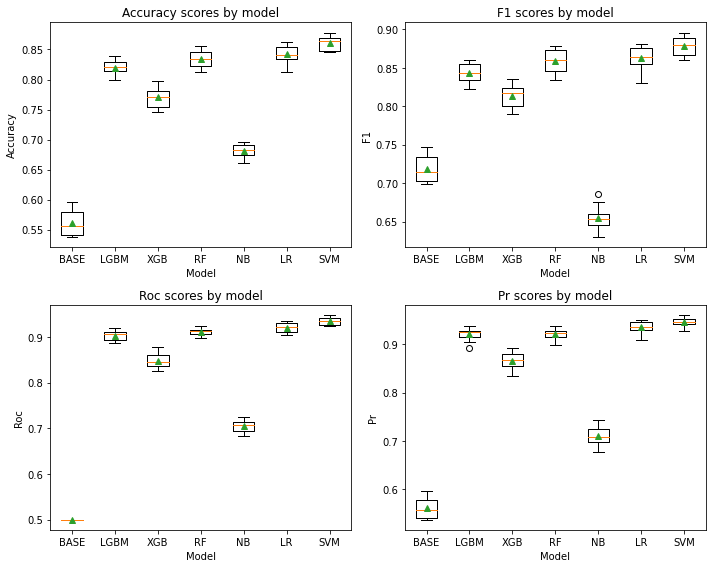

In [ ]:
fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(10,8))
axs = axs.ravel()  # To get a flattened array

for i, m in enumerate(['test_accuracy', 'test_f1', 'test_roc_auc', 'test_pr_auc']):
    plot_boxplot(scores_all, m, axs[i])
plt.tight_layout()